In [24]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Loading dataset...
Loaded dataset with 120 samples and 87 features.
Training model with hyperparameter tuning...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best parameters: {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Evaluating model...
Classification Report:
              precision    recall  f1-score   support

      Unripe       0.92      1.00      0.96        11
        Ripe       1.00      0.92      0.96        13

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



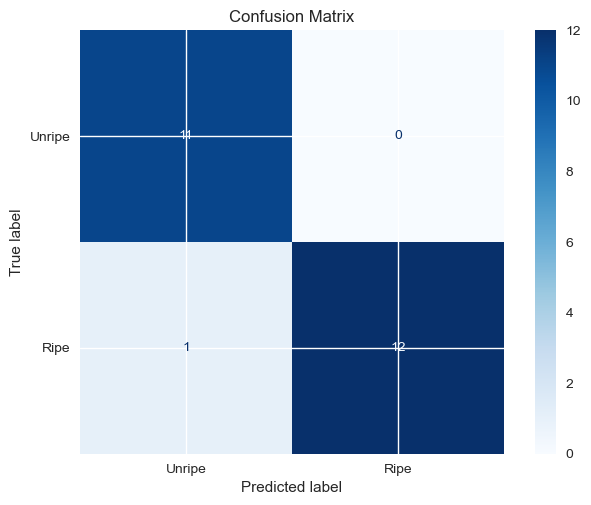

Visualizing feature distributions...


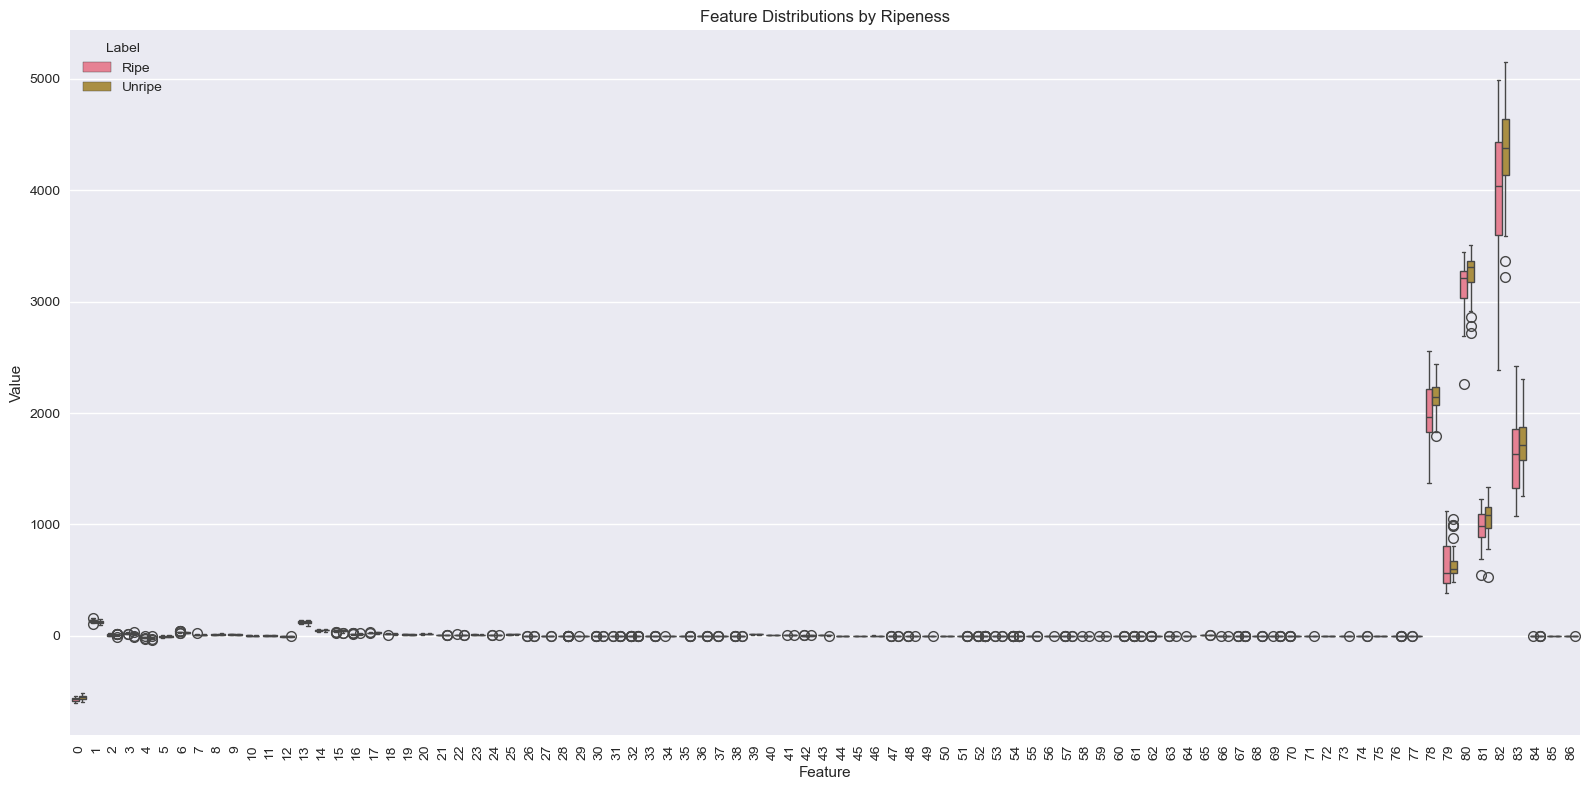

Visualizing 2D scatter of cepstral-based features...


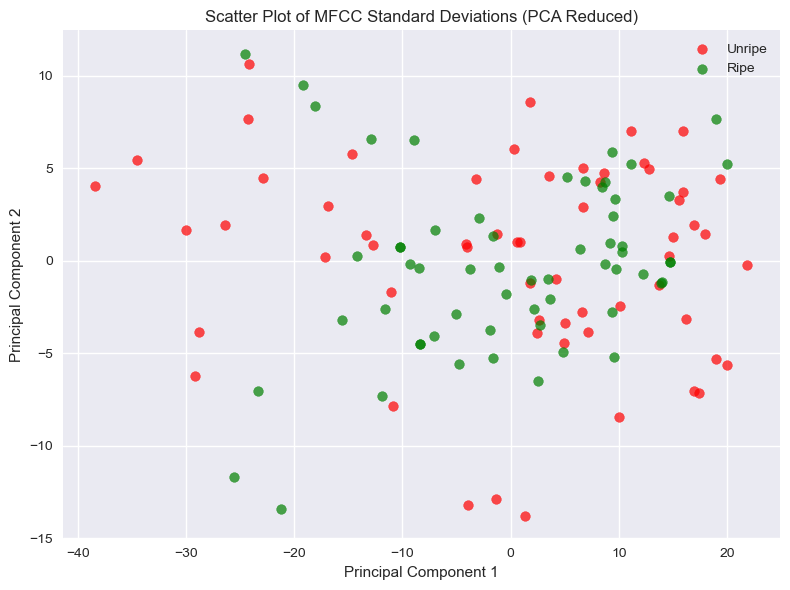

Model saved to ripeness_model.pkl, scaler saved to scaler.pkl


In [30]:
class CantaloupeRipenessClassifier:
    """
    A classifier for determining cantaloupe ripeness using enriched audio features and an SVM.
    """

    def __init__(self, sample_rate=44100, duration=7, n_mfcc=13):
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_mfcc = n_mfcc
        self.model = None
        self.scaler = None

    def extract_features(self, file_path):
        """
        Extracts rich audio features for classification.
        """
        try:
            y, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.duration)

            # MFCC
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
            mfcc_mean = np.mean(mfcc, axis=1)
            mfcc_std = np.std(mfcc, axis=1)

            # Delta & Delta-Delta
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)
            delta_mean = np.mean(delta, axis=1)
            delta_std = np.std(delta, axis=1)
            delta2_mean = np.mean(delta2, axis=1)
            delta2_std = np.std(delta2, axis=1)

            # Other spectral features
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            zcr_mean = np.mean(zcr)

            centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
            rms = librosa.feature.rms(y=y)[0]

            spectral_features = [
                np.mean(centroid), np.std(centroid),
                np.mean(bandwidth), np.std(bandwidth),
                np.mean(rolloff), np.std(rolloff),
                np.mean(rms), np.std(rms),
                zcr_mean
            ]

            features = np.concatenate([
                mfcc_mean, mfcc_std,
                delta_mean, delta_std,
                delta2_mean, delta2_std,
                spectral_features
            ])
            return features

        except Exception as e:
            print(f"Error extracting features from {file_path}: {e}")
            return None

    def load_dataset(self, ripe_dir, unripe_dir):
        """
        Load ripe and unripe samples from directories.
        """
        features = []
        labels = []

        for label, directory in zip([1, 0], [ripe_dir, unripe_dir]):
            for file in os.listdir(directory):
                if file.endswith('.wav'):
                    path = os.path.join(directory, file)
                    feat = self.extract_features(path)
                    if feat is not None:
                        features.append(feat)
                        labels.append(label)

        X = np.array(features)
        y = np.array(labels)
        return X, y

    def train_model(self, X, y, tune=False):
        """
        Train SVM classifier. Optionally perform grid search for hyperparameter tuning.
        """
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        if tune:
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'degree': [2, 3, 4],
                'gamma': ['scale', 'auto', 0.01, 0.001],
                'class_weight': [None, 'balanced']
            }
            grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
            grid.fit(X_scaled, y)
            self.model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
        else:
            self.model = SVC(kernel='poly', degree=3, C=1.0)
            self.model.fit(X_scaled, y)

    def evaluate_model(self, X, y):
        """
        Print classification report and display confusion matrix.
        """
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)

        print("Classification Report:")
        print(classification_report(y, predictions, target_names=['Unripe', 'Ripe']))

        cm = confusion_matrix(y, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unripe', 'Ripe'])
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix")
        plt.show()

    def save_model(self, model_path='ripeness_model.pkl', scaler_path='scaler.pkl'):
        """
        Save model and scaler.
        """
        joblib.dump(self.model, model_path)
        joblib.dump(self.scaler, scaler_path)
        print(f"Model saved to {model_path}, scaler saved to {scaler_path}")

    def load_model(self, model_path='ripeness_model.pkl', scaler_path='scaler.pkl'):
        """
        Load model and scaler.
        """
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        print("Model and scaler loaded.")

    def predict_file(self, file_path):
        """
        Predict the ripeness of a single audio file.
        """
        features = self.extract_features(file_path)
        if features is None:
            return "Error"
        features_scaled = self.scaler.transform([features])
        prediction = self.model.predict(features_scaled)[0]
        return 'Ripe' if prediction == 1 else 'Unripe'

    def plot_feature_distributions(self, X, y):
        """
        Plot feature distributions using seaborn.
        """
        df = pd.DataFrame(X)
        df['Label'] = y
        df['Label'] = df['Label'].map({1: 'Ripe', 0: 'Unripe'})

        melted_df = df.melt(id_vars='Label', var_name='Feature', value_name='Value')
        plt.figure(figsize=(16, 8))
        sns.boxplot(x='Feature', y='Value', hue='Label', data=melted_df)
        plt.title('Feature Distributions by Ripeness')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def plot_scatter_features(self, X, y):
        """
        Plot a 2D scatter plot of the MFCC standard deviations or PCA-transformed features.
        """
        # MFCC std features start from index n_mfcc to 2*n_mfcc - 1
        mfcc_std_start = self.n_mfcc
        mfcc_std_end = 2 * self.n_mfcc
        X_mfcc_std = X[:, mfcc_std_start:mfcc_std_end]

        # Reduce dimensions to 2 using PCA for visualization
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X_mfcc_std)

        plt.figure(figsize=(8, 6))
        for label, color, name in zip([0, 1], ['red', 'green'], ['Unripe', 'Ripe']):
            idx = (y == label)
            plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], label=name, alpha=0.7, c=color)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title("Scatter Plot of MFCC Standard Deviations (PCA Reduced)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    classifier = CantaloupeRipenessClassifier()

    # Paths to your dataset
    ripe_dir = 'data/ripe'
    unripe_dir = 'data/unripe'

    print("Loading dataset...")
    X, y = classifier.load_dataset(ripe_dir, unripe_dir)

    if X.size == 0 or y.size == 0:
        print("Dataset loading failed. Check if the audio files exist and are accessible.")
    else:
        print(f"Loaded dataset with {X.shape[0]} samples and {X.shape[1]} features.")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print("Training model with hyperparameter tuning...")
        classifier.train_model(X_train, y_train, tune=True)

        print("Evaluating model...")
        classifier.evaluate_model(X_test, y_test)

        print("Visualizing feature distributions...")
        classifier.plot_feature_distributions(X, y)

        print("Visualizing 2D scatter of cepstral-based features...")
        classifier.plot_scatter_features(X, y)

        # Save model and scaler
        classifier.save_model()

In [ ]:
    # Predict an example
    example_file = 'example.wav'
    result = classifier.predict_file(example_file)
    print(f"{example_file} is classified as: {result}")
